In [14]:
import tensorflow as tf
tf.__version__
tf.compat.v1.disable_eager_execution()

import numpy as np
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Lambda, Conv1D, maximum, GlobalMaxPooling1D, Dense, GaussianNoise, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import non_neg
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import pandas as pd
import logomaker

import random
import tqdm
from tqdm import trange
from subprocess import Popen, PIPE, run
import sys
import pickle
from pyfaidx import Fasta
from  tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
import random
import glob
import bioframe
import os
import tempfile
from collections import Counter
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.mixture import GaussianMixture
from multiprocessing import Pool

In [15]:
def run_imap_multiprocessing(func, argument_list, num_processes):

    pool = Pool(processes=num_processes)

    result_list_tqdm = []
    for result in tqdm.tqdm(pool.imap(func=func, iterable=argument_list), total=len(argument_list)):
        result_list_tqdm.append(result)

    return result_list_tqdm

def ppm_to_pwm(ppm):
    pwm = ppm + 1e-5
    pwm = pwm / 0.25
    pwm = np.log2(pwm)
    return(pwm)

def flatten(xss):
    return [x for xs in xss for x in xs]

def get_information_content(x):
    ic = x * np.log2((x + .001) / .25)
    if ic > 0:
        return(ic)
    else:
        return(0.0)
    
def get_ZMotif_motifs(motifs_file):
    TF, cycle = motifs_file.split("/")[-2].split("-")[:2]
    
    df = pd.read_csv(motifs_file, sep="\t", header=0)
    auc = df.iloc[0].auc
    model = GaussianMixture(2).fit(df.score.values.reshape(-1,1))
    x = np.linspace(np.min(df.score.values), np.max(df.score.values), 1000)
    logprob = model.score_samples(x.reshape(-1, 1))
    probs = model.predict_proba(x.reshape(-1, 1))
    means = model.means_
    index = np.argmax(means)
    thresh = x[np.where(probs[:,index] > 0.5)[0]][0]
    
    # for plotting
    
    # responsibilities = model.predict_proba(x.reshape(-1, 1))
    # pdf = np.exp(logprob)
    # pdf_individual = responsibilities * pdf[:, np.newaxis]
    # fig, ax = plt.subplots()
    # _ = ax.hist(df.score, 100, density=True, histtype='stepfilled', alpha=0.4)
    # ax.plot(x, pdf, '-k')
    # ax.plot(x, pdf_individual, '--k')
    # ymin, ymax = ax.get_ylim()
    # ax.vlines(x = thresh ,ymin=ymin, ymax=ymax)
    tmp_df = df[(df["score"] > thresh)]
    ppm = logomaker.alignment_to_matrix(tmp_df.seq, to_type="counts")
    ppm = ppm[["A", "C", "G", "T"]]
    ppm = ppm.div(ppm.sum(axis=1), axis=0)
    return([TF, cycle, thresh, tmp_df.shape[0], auc, ppm])

In [16]:
results_dir = "../Results/PWM-A2G-ZMotif/"
motifs_files = sorted([x for x in glob.glob("{}/*/motifs.txt.gz".format(results_dir))])
print("There are {} motifs files".format(len(motifs_files)))

There are 75 motifs files


In [17]:
PPMs = run_imap_multiprocessing(func=get_ZMotif_motifs, argument_list=motifs_files, num_processes=10)

100%|██████████| 75/75 [00:51<00:00,  1.46it/s]


In [18]:
L_TFs = ["LEF1", "NACC2", "NFKB1", "RORB","TIGD3"]
F_TFs = [x for x in os.listdir("/home/gregory.andrews-umw/IBIS/data/HTS/") if x not in L_TFs]

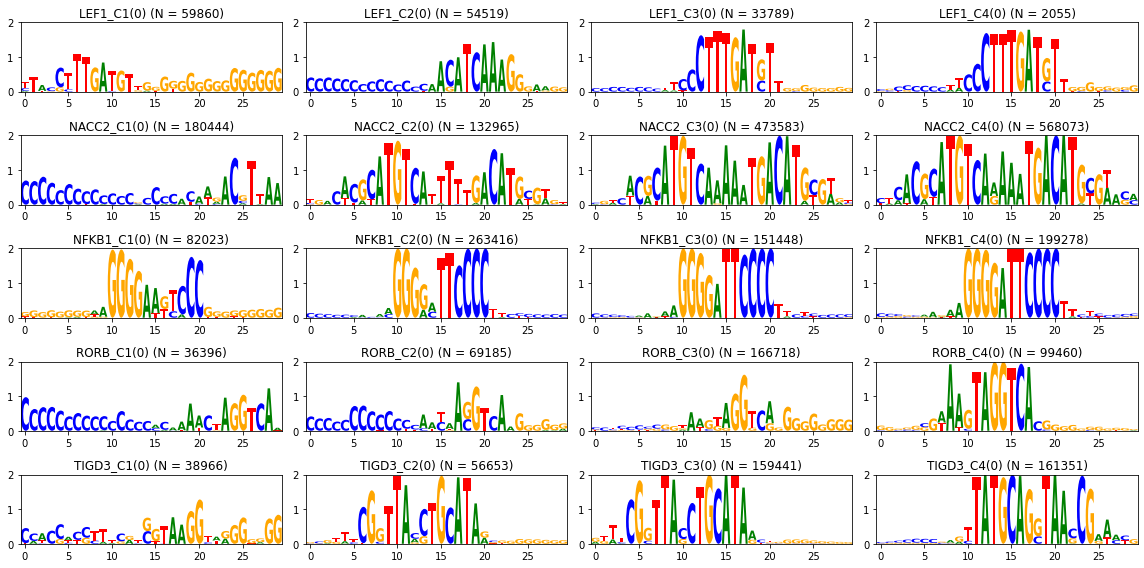

In [19]:
fig, axes = plt.subplots(5,4, tight_layout=True, figsize=(16,8))
with open("PWM-A2G-Leaderboard.txt", "w") as f:
    plot_i = 0
    for tf in L_TFs:
        for i in range(1,5):
            cycle = "C{}".format(i)
            tmp_PPMs =  [x for x in PPMs if x[0] == tf and x[1] == cycle]
            if len(tmp_PPMs) == 0:
                plot_i += 1
            else:
                tmp_AUCs = [x[-2] for x in tmp_PPMs]
                ppm_i = np.argmax(tmp_AUCs)
                ppm = tmp_PPMs[ppm_i][-1]
                n = tmp_PPMs[ppm_i][-3]
                ax = axes.flatten()[plot_i]
                logomaker.Logo(ppm.applymap(get_information_content), ax=ax)
                ax.set_title("{}_{}({}) (N = {})".format(tf, cycle, ppm_i, n))
                ax.set_ylim([0,2])
                plot_i += 1
                print(">{0} {0}_{1}".format(tf, cycle), file=f)
                for i in range(ppm.shape[0]):
                    print(" ".join(["%.5f" % v for v in ppm.values[i,:]]), file=f)
                print(file=f)

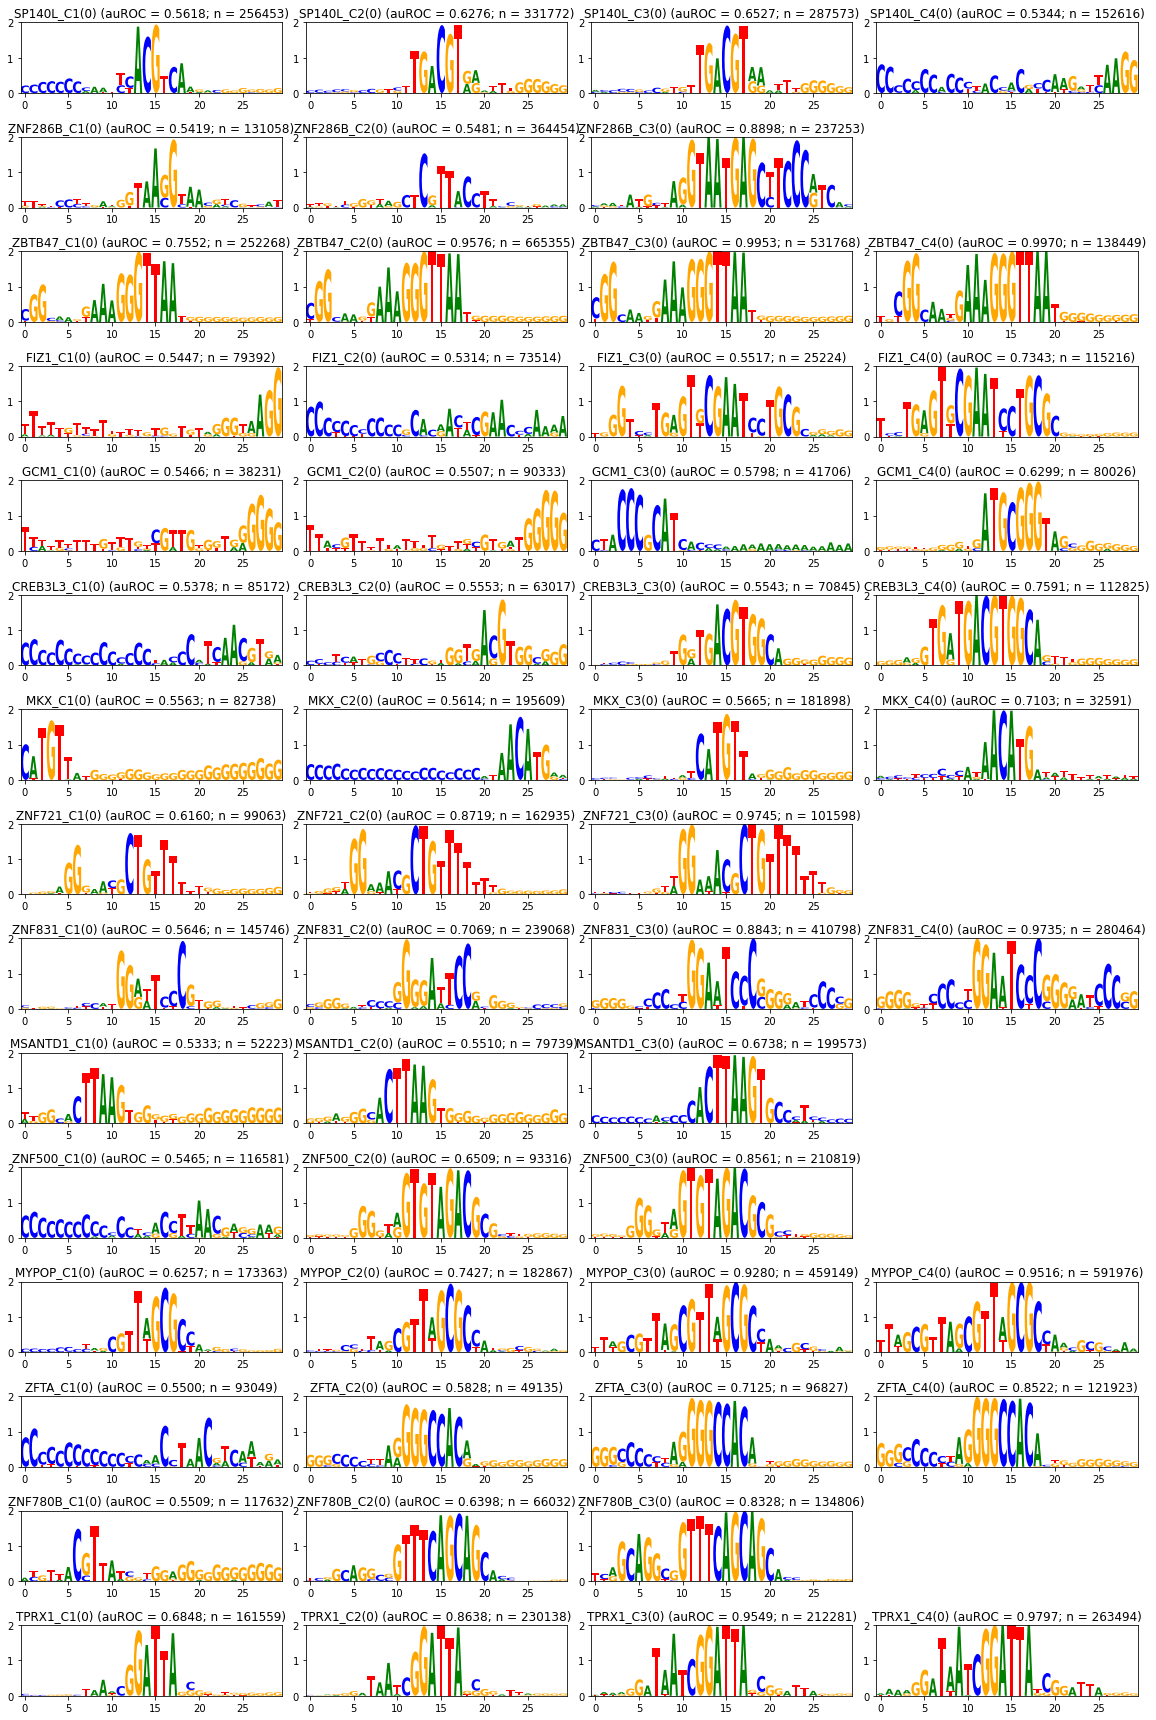

In [21]:
fig, axes = plt.subplots(15,4, tight_layout=True, figsize=(16,24))
with open("PWM-A2G-Final.txt", "w") as f:
    plot_i = 0
    for tf in F_TFs:
        for i in range(1,5):
            cycle = "C{}".format(i)
            tmp_PPMs =  [x for x in PPMs if x[0] == tf and x[1] == cycle]
            if len(tmp_PPMs) == 0:
                ax = axes.flatten()[plot_i]
                fig.delaxes(ax)
                plot_i += 1
            else:
                tmp_AUCs = [x[-2] for x in tmp_PPMs]
                ppm_i = np.argmax(tmp_AUCs)
                auc = np.max(tmp_AUCs)
                ppm = tmp_PPMs[ppm_i][-1]
                n = tmp_PPMs[ppm_i][-3]
                ax = axes.flatten()[plot_i]
                logomaker.Logo(ppm.applymap(get_information_content), ax=ax)
                ax.set_title("{}_{}({}) (auROC = {:.4f}; n = {})".format(tf, cycle, ppm_i, auc, n))
                ax.set_ylim([0,2])
                plot_i += 1
                print(">{0} {0}_{1}".format(tf, cycle), file=f)
                for i in range(ppm.shape[0]):
                    print(" ".join(["%.5f" % v for v in ppm.values[i,:]]), file=f)
                print(file=f)